### Imports and Assists

In [1]:
# Imports and constants

import os
os.environ['LOKY_MAX_CPU_COUNT'] = '8'
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from skimage.feature import hog

In [2]:
# ML imports

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Models

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# HOG dependencies (auto-installs if anything is missing)

try:
    from skimage.feature import hog
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-image"])
    from skimage.feature import hog

In [5]:
# Extra stuff to make life easier by doing less... LOL

random_state = 42
np.random.seed(random_state)

In [6]:
# dataset path

BASE_DIR = "APPLE_DISEASE_DATASET"
img_size = (48,48)

### Loading Dataset and accessing images from dataset

In [7]:
def load_dataset(BASE_DIR, image_size=(48,48)):
    images, labels, originals = [], [], []
    class_names = [c for c in sorted(os.listdir(BASE_DIR)) if os.path.isdir(os.path.join(BASE_DIR, c))]
    for class_name in class_names:
        class_path = os.path.join(BASE_DIR, class_name)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            img = cv2.imread(fpath)  # BGR
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            originals.append(img_rgb)
            images.append(img_rgb.flatten())
            labels.append(class_name)
    return np.array(images), np.array(labels), np.array(originals), class_names

In [8]:
X, y, originals, class_names = load_dataset(BASE_DIR, image_size=img_size)
print("Samples:", X.shape[0])
print("Features per image:", X.shape[1])
print("Classs:", class_names)

Samples: 419
Features per image: 6912
Classs: ['APPLE ROT LEAVES', 'HEALTHY LEAVES', 'LEAF BLOTCH', 'SCAB LEAVES']


### Function for plotting Confusion Matrix

In [9]:
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2. if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j,i, format(cm[i,j], 'd'),
                     ha = "center", va = "center",
                     color = "white" if cm[i,j] > thresh else "black")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

### Function for plotting Accuracy Table

In [10]:
def plot_accuracy_table(df, title="Model Accuracy Comparison"):
    plt.figure(figsize=(8,5))
    bars = plt.barh(df["Model"], df["Accuracy"])
    plt.xlabel("Accuracy")
    plt.title(title)
    plt.gca().invert_yaxis()
    for bar in bars:
        w = bar.get_width()
        plt.text(w + 0.01, bar.get_y() + bar.get_height()/2, f"{w:.2f}", va='center')
    plt.xlim(0, 1.0)
    plt.grid()
    plt.tight_layout()
    plt.show()

### Function for reshaphing images

In [11]:
def _reshape_rgb_flat(row, img_size=img_size):
    return row.reshape(img_size[0], img_size[1], 3).astype(np.uint8)

### No denoising function

In [12]:
def denoise_none(X):
    return X.copy()

### Gaussian denoising function

In [13]:
def denoise_gaussian(X):
    out = []
    for row in X:
        img = _reshape_rgb_flat(row)
        den = cv2.GaussianBlur(img, (5,5), 0)
        out.append(den.flatten())
    return np.array(out)

### Median denoising function

In [14]:
def denoise_median(X):
    out = []
    for row in X:
        img = _reshape_rgb_flat(row)
        den = cv2.medianBlur(img, 5)
        out.append(den.flatten())
    return np.array(out)

### Bilateral denoising function

In [15]:
def denoise_bilateral(X):
    out = []
    for row in X:
        img = _reshape_rgb_flat(row)
        den = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
        out.append(den.flatten())
    return np.array(out)

### Colored NLMeans denoising function

In [16]:
def denoise_nlmeans_colored(X, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21):
    out = []
    for row in X:
        img = _reshape_rgb_flat(row)
        den = cv2.fastNlMeansDenoisingColored(img, None, hColor, templateWindowSize, searchWindowSize)
        out.append(den.flatten())
    return np.array(out)

### Building a function to run all Classifiers in one go

In [17]:
# building Classifier factory
def build_classifiers():
    #param_grid = 
    models = OrderedDict()
    models["SVM (Linear)"] = SVC(kernel="linear", C=1, class_weight="balanced", random_state= random_state, max_iter=5000)
    models["SVM (RBF)"] = SVC(kernel="rbf", C=10, class_weight="balanced",  gamma=0.001, random_state=random_state)
    #models["SVM (GridSearchCV)"] = 
    models["Logistic Regression"] = LogisticRegression(max_iter=5000, random_state=random_state)
    models["KNN"] = KNeighborsClassifier(n_neighbors=3)
    models["Random Forest"] = RandomForestClassifier(n_estimators=100, random_state=random_state)
    models["Gradient Boosting"] = GradientBoostingClassifier(random_state=random_state)
    models["Naive Bayes"] = GaussianNB()
    return models

### Running all Classifiers to avoid repeated works

In [18]:
def run_all_classifiers(X_data, y_data, originals_data, label="Experiment", show_confusion=False, classes=None):
    X_train, X_test, y_train, y_test, train_orig, test_orig = train_test_split(
        X_data, y_data, originals_data, test_size=0.2, random_state=random_state
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    models = build_classifiers()
    # Add SVM GridSearchCV (RBF)
    param_grid = {
        "C": [0.1, 1, 5, 10, 50],
        "gamma": ["scale", 0.001, 0.01, 0.1],
        "kernel": ["rbf"]
    }
    grid_svm = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, refit=True, n_jobs=-1)
    models["SVM (GridSearch RBF)"] = grid_svm

    accs = OrderedDict()

    print(f"\n ==== {label} ====")
    for name, clf in models.items():
        clf.fit(X_train_s, y_train)
        y_pred = clf.predict(X_test_s)
        acc = accuracy_score(y_test, y_pred)
        accs[name] = acc
        print(f"{name}: accuracy = {acc:.3f}")
        print(classification_report(y_test, y_pred))
        if show_confusion and classes is not None:
            cm = confusion_matrix(y_test, y_pred, labels=classes)
            plot_confusion_matrix(cm, classes=classes, title=f"{label} --> {name}")

    df = pd.DataFrame({"Model": list(accs.keys()), "Accuracy": list(accs.values())})
    df = df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
    display(df)
    return accs, df

###  Running No Denoising techniques for all Classifiers and Plotting accuracy table


 ==== Baseline (No Denoising) ====
SVM (Linear): accuracy = 0.488
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.64      0.50      0.56        28
  HEALTHY LEAVES       0.31      0.57      0.40         7
     LEAF BLOTCH       0.47      0.53      0.50        15
     SCAB LEAVES       0.47      0.44      0.45        34

        accuracy                           0.49        84
       macro avg       0.47      0.51      0.48        84
    weighted avg       0.51      0.49      0.49        84



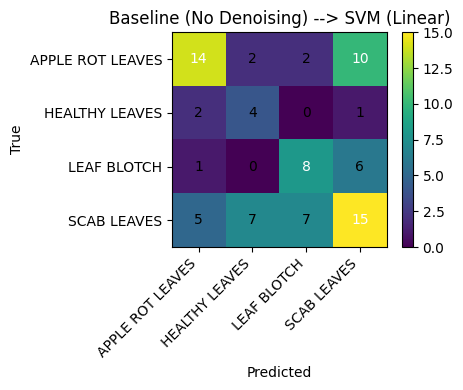

SVM (RBF): accuracy = 0.476
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.86      0.21      0.34        28
  HEALTHY LEAVES       0.00      0.00      0.00         7
     LEAF BLOTCH       0.50      0.20      0.29        15
     SCAB LEAVES       0.44      0.91      0.60        34

        accuracy                           0.48        84
       macro avg       0.45      0.33      0.31        84
    weighted avg       0.55      0.48      0.41        84



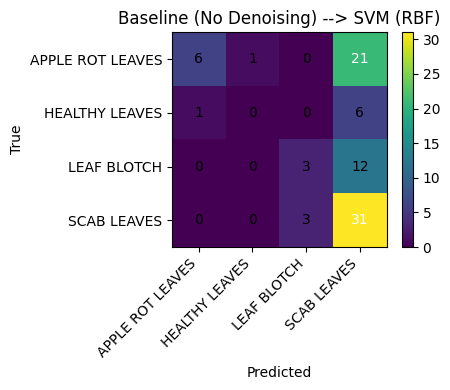

Logistic Regression: accuracy = 0.536
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.74      0.50      0.60        28
  HEALTHY LEAVES       0.56      0.71      0.62         7
     LEAF BLOTCH       0.44      0.53      0.48        15
     SCAB LEAVES       0.47      0.53      0.50        34

        accuracy                           0.54        84
       macro avg       0.55      0.57      0.55        84
    weighted avg       0.56      0.54      0.54        84



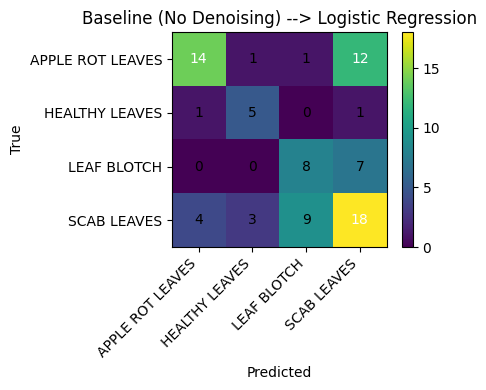

KNN: accuracy = 0.548
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.76      0.46      0.58        28
  HEALTHY LEAVES       0.50      0.57      0.53         7
     LEAF BLOTCH       0.43      0.60      0.50        15
     SCAB LEAVES       0.53      0.59      0.56        34

        accuracy                           0.55        84
       macro avg       0.55      0.56      0.54        84
    weighted avg       0.59      0.55      0.55        84



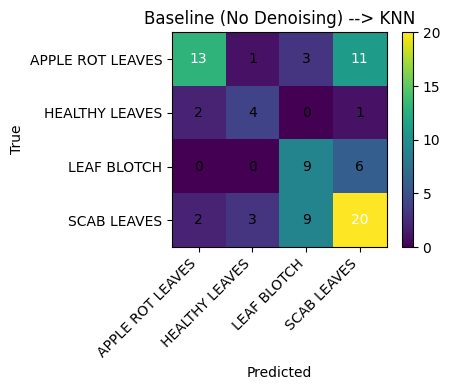

Random Forest: accuracy = 0.560
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.72      0.46      0.57        28
  HEALTHY LEAVES       0.42      0.71      0.53         7
     LEAF BLOTCH       0.50      0.67      0.57        15
     SCAB LEAVES       0.56      0.56      0.56        34

        accuracy                           0.56        84
       macro avg       0.55      0.60      0.56        84
    weighted avg       0.59      0.56      0.56        84



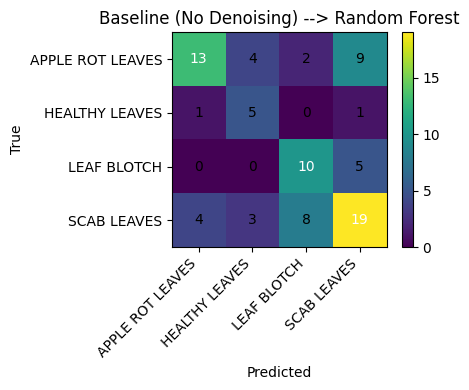

Gradient Boosting: accuracy = 0.548
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.74      0.50      0.60        28
  HEALTHY LEAVES       0.50      0.71      0.59         7
     LEAF BLOTCH       0.46      0.40      0.43        15
     SCAB LEAVES       0.50      0.62      0.55        34

        accuracy                           0.55        84
       macro avg       0.55      0.56      0.54        84
    weighted avg       0.57      0.55      0.55        84



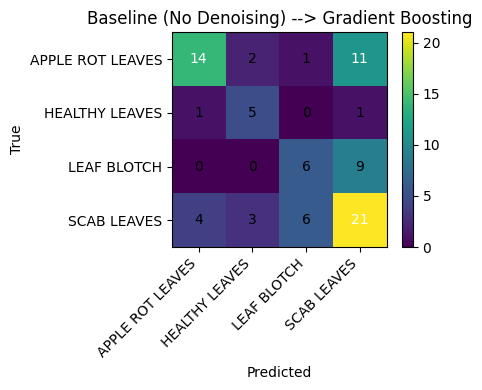

Naive Bayes: accuracy = 0.357
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.58      0.25      0.35        28
  HEALTHY LEAVES       0.29      1.00      0.45         7
     LEAF BLOTCH       0.31      0.87      0.46        15
     SCAB LEAVES       0.50      0.09      0.15        34

        accuracy                           0.36        84
       macro avg       0.42      0.55      0.35        84
    weighted avg       0.48      0.36      0.30        84



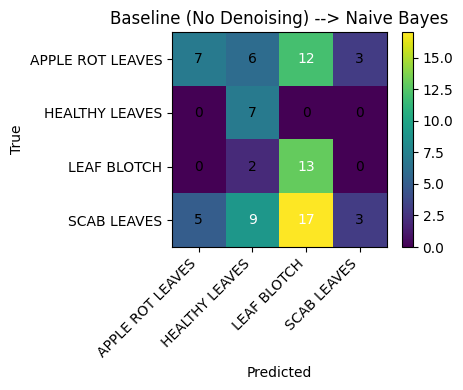

Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM (GridSearch RBF): accuracy = 0.619
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.73      0.57      0.64        28
  HEALTHY LEAVES       0.50      0.71      0.59         7
     LEAF BLOTCH       0.60      0.80      0.69        15
     SCAB LEAVES       0.59      0.56      0.58        34

        accuracy                           0.62        84
       macro avg       0.61      0.66      0.62        84
    weighted avg       0.63      0.62      0.62        84



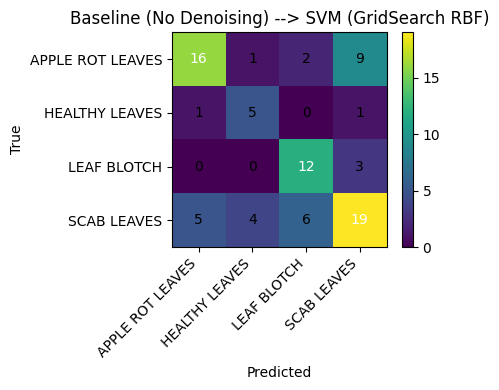

,Model,Accuracy
0,SVM (GridSearch RBF),0.619048
1,Random Forest,0.559524
2,KNN,0.547619
3,Gradient Boosting,0.547619
4,Logistic Regression,0.535714
5,SVM (Linear),0.488095
6,SVM (RBF),0.476190
7,Naive Bayes,0.357143


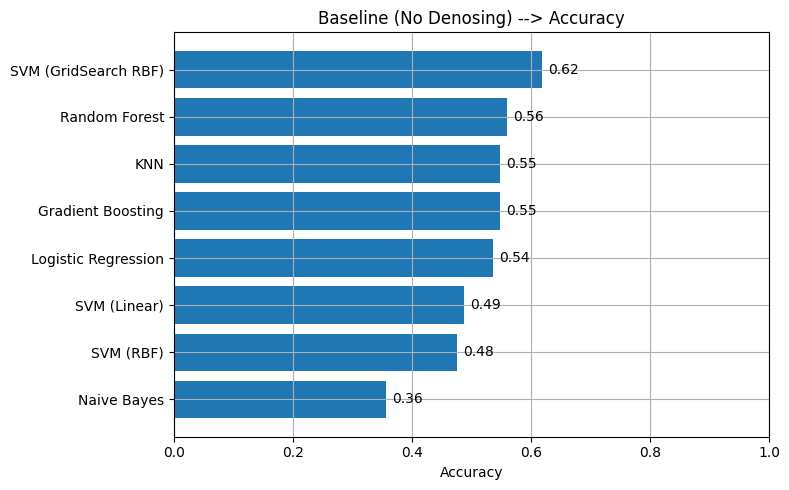

In [19]:
X_baseline = denoise_none(X)
acc_orig, df_orig = run_all_classifiers(
    X_baseline, y, originals, label="Baseline (No Denoising)", show_confusion=True, classes=class_names
)
plot_accuracy_table(df_orig, title="Baseline (No Denosing) --> Accuracy")

### Looping through all Denoisers and applying all Classifiers. Then plotting 


 >>> Applying Gaussian denoising...

 ==== Gaussian Denoising ====
SVM (Linear): accuracy = 0.512
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.59      0.57      0.58        28
  HEALTHY LEAVES       0.25      0.29      0.27         7
     LEAF BLOTCH       0.50      0.53      0.52        15
     SCAB LEAVES       0.52      0.50      0.51        34

        accuracy                           0.51        84
       macro avg       0.46      0.47      0.47        84
    weighted avg       0.52      0.51      0.51        84



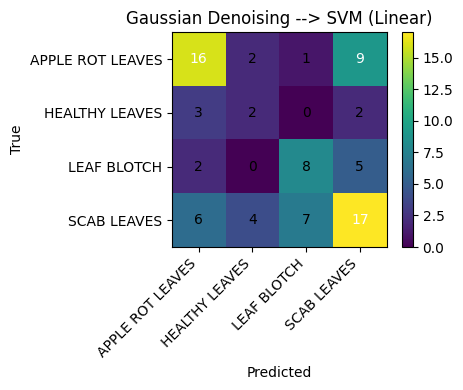

SVM (RBF): accuracy = 0.488
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.82      0.32      0.46        28
  HEALTHY LEAVES       0.00      0.00      0.00         7
     LEAF BLOTCH       0.44      0.27      0.33        15
     SCAB LEAVES       0.44      0.82      0.58        34

        accuracy                           0.49        84
       macro avg       0.43      0.35      0.34        84
    weighted avg       0.53      0.49      0.45        84



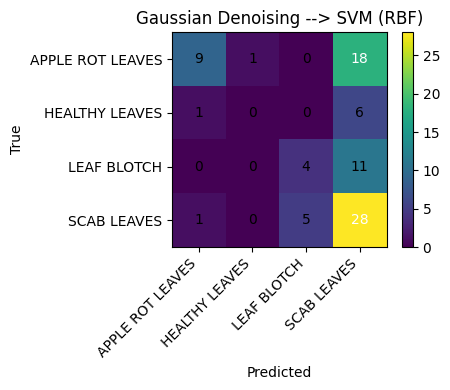

Logistic Regression: accuracy = 0.560
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.71      0.54      0.61        28
  HEALTHY LEAVES       0.50      0.43      0.46         7
     LEAF BLOTCH       0.50      0.53      0.52        15
     SCAB LEAVES       0.51      0.62      0.56        34

        accuracy                           0.56        84
       macro avg       0.56      0.53      0.54        84
    weighted avg       0.58      0.56      0.56        84



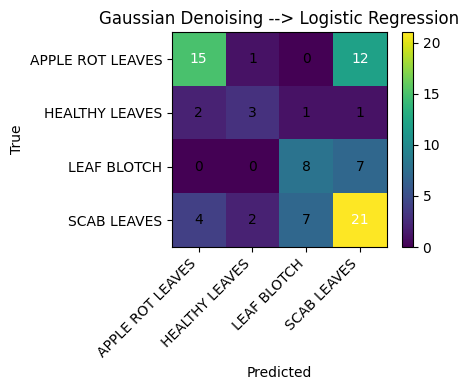

KNN: accuracy = 0.512
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.64      0.50      0.56        28
  HEALTHY LEAVES       0.50      0.57      0.53         7
     LEAF BLOTCH       0.37      0.47      0.41        15
     SCAB LEAVES       0.51      0.53      0.52        34

        accuracy                           0.51        84
       macro avg       0.50      0.52      0.51        84
    weighted avg       0.53      0.51      0.52        84



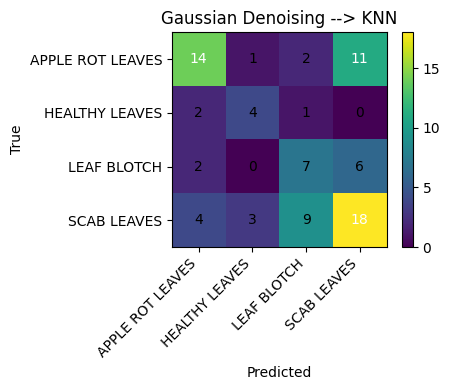

Random Forest: accuracy = 0.571
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.75      0.54      0.62        28
  HEALTHY LEAVES       0.42      0.71      0.53         7
     LEAF BLOTCH       0.60      0.60      0.60        15
     SCAB LEAVES       0.51      0.56      0.54        34

        accuracy                           0.57        84
       macro avg       0.57      0.60      0.57        84
    weighted avg       0.60      0.57      0.58        84



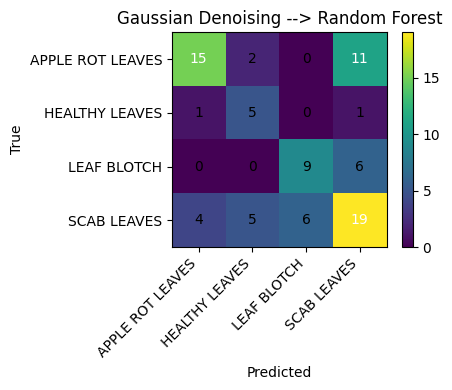

Gradient Boosting: accuracy = 0.631
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.76      0.57      0.65        28
  HEALTHY LEAVES       0.56      0.71      0.62         7
     LEAF BLOTCH       0.57      0.80      0.67        15
     SCAB LEAVES       0.61      0.59      0.60        34

        accuracy                           0.63        84
       macro avg       0.62      0.67      0.64        84
    weighted avg       0.65      0.63      0.63        84



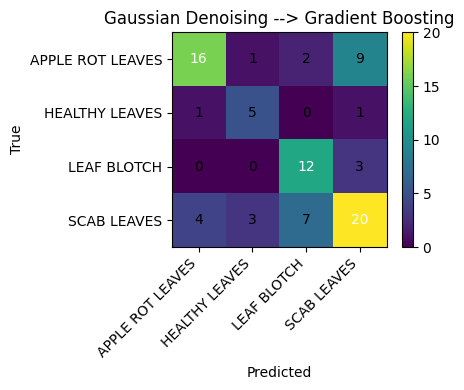

Naive Bayes: accuracy = 0.369
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.54      0.25      0.34        28
  HEALTHY LEAVES       0.33      1.00      0.50         7
     LEAF BLOTCH       0.31      0.87      0.46        15
     SCAB LEAVES       0.50      0.12      0.19        34

        accuracy                           0.37        84
       macro avg       0.42      0.56      0.37        84
    weighted avg       0.46      0.37      0.31        84



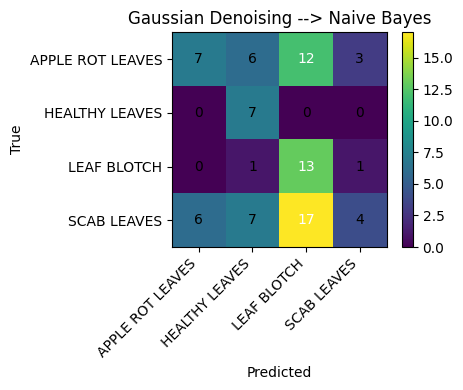

Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM (GridSearch RBF): accuracy = 0.643
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.82      0.64      0.72        28
  HEALTHY LEAVES       0.45      0.71      0.56         7
     LEAF BLOTCH       0.58      0.73      0.65        15
     SCAB LEAVES       0.62      0.59      0.61        34

        accuracy                           0.64        84
       macro avg       0.62      0.67      0.63        84
    weighted avg       0.67      0.64      0.65        84



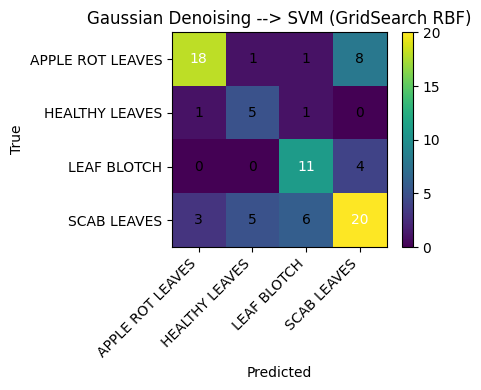

,Model,Accuracy
0,SVM (GridSearch RBF),0.642857
1,Gradient Boosting,0.630952
2,Random Forest,0.571429
3,Logistic Regression,0.559524
4,SVM (Linear),0.511905
5,KNN,0.511905
6,SVM (RBF),0.488095
7,Naive Bayes,0.369048


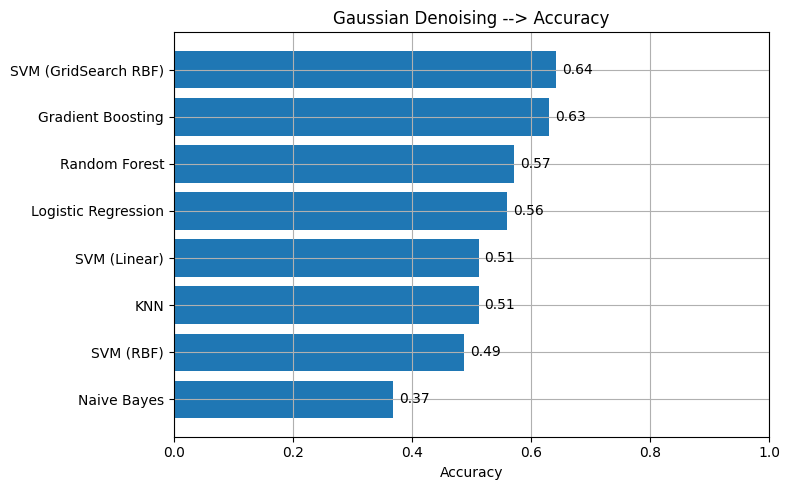


 >>> Applying Median denoising...

 ==== Median Denoising ====
SVM (Linear): accuracy = 0.524
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.74      0.61      0.67        28
  HEALTHY LEAVES       0.29      0.57      0.38         7
     LEAF BLOTCH       0.44      0.47      0.45        15
     SCAB LEAVES       0.52      0.47      0.49        34

        accuracy                           0.52        84
       macro avg       0.49      0.53      0.50        84
    weighted avg       0.56      0.52      0.53        84



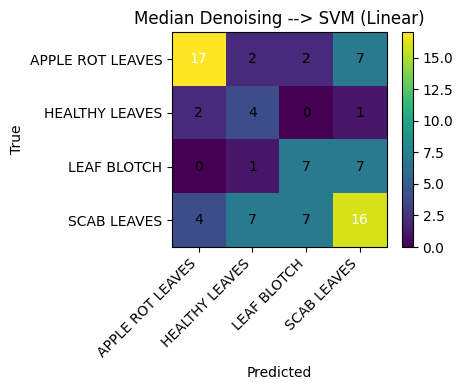

SVM (RBF): accuracy = 0.476
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.82      0.32      0.46        28
  HEALTHY LEAVES       0.00      0.00      0.00         7
     LEAF BLOTCH       0.38      0.20      0.26        15
     SCAB LEAVES       0.44      0.82      0.57        34

        accuracy                           0.48        84
       macro avg       0.41      0.34      0.32        84
    weighted avg       0.52      0.48      0.43        84



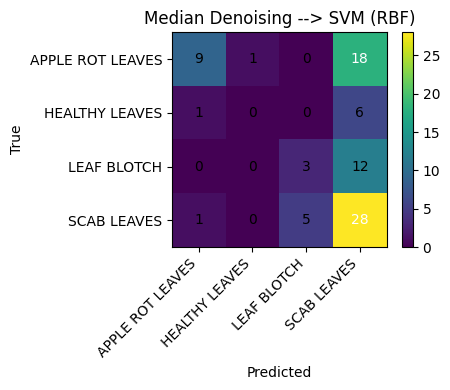

Logistic Regression: accuracy = 0.548
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.74      0.61      0.67        28
  HEALTHY LEAVES       0.43      0.43      0.43         7
     LEAF BLOTCH       0.40      0.53      0.46        15
     SCAB LEAVES       0.53      0.53      0.53        34

        accuracy                           0.55        84
       macro avg       0.52      0.52      0.52        84
    weighted avg       0.57      0.55      0.55        84



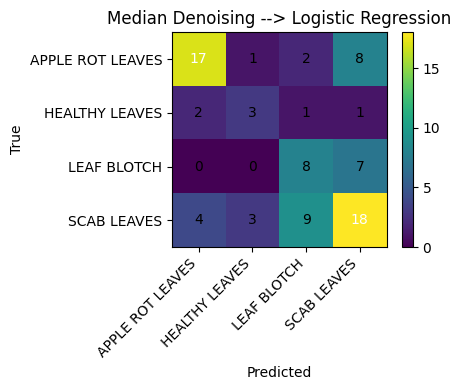

KNN: accuracy = 0.548
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.62      0.54      0.58        28
  HEALTHY LEAVES       0.50      0.57      0.53         7
     LEAF BLOTCH       0.42      0.53      0.47        15
     SCAB LEAVES       0.58      0.56      0.57        34

        accuracy                           0.55        84
       macro avg       0.53      0.55      0.54        84
    weighted avg       0.56      0.55      0.55        84



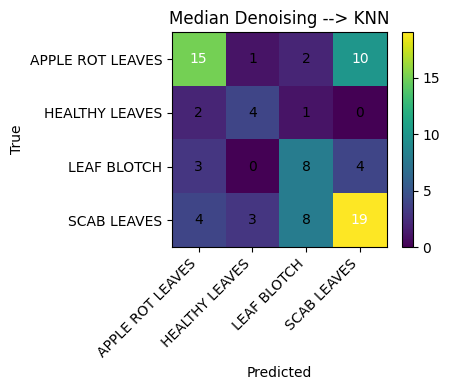

Random Forest: accuracy = 0.548
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.77      0.61      0.68        28
  HEALTHY LEAVES       0.42      0.71      0.53         7
     LEAF BLOTCH       0.38      0.53      0.44        15
     SCAB LEAVES       0.55      0.47      0.51        34

        accuracy                           0.55        84
       macro avg       0.53      0.58      0.54        84
    weighted avg       0.58      0.55      0.56        84



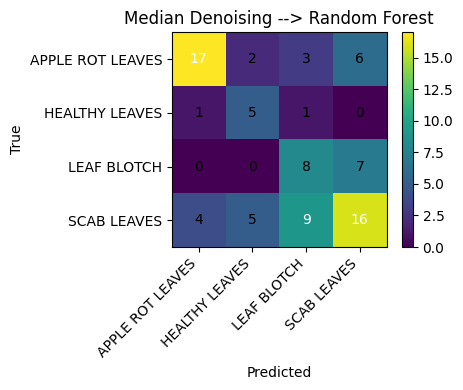

Gradient Boosting: accuracy = 0.643
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.65      0.54      0.59        28
  HEALTHY LEAVES       0.56      0.71      0.62         7
     LEAF BLOTCH       0.71      0.80      0.75        15
     SCAB LEAVES       0.63      0.65      0.64        34

        accuracy                           0.64        84
       macro avg       0.64      0.67      0.65        84
    weighted avg       0.64      0.64      0.64        84



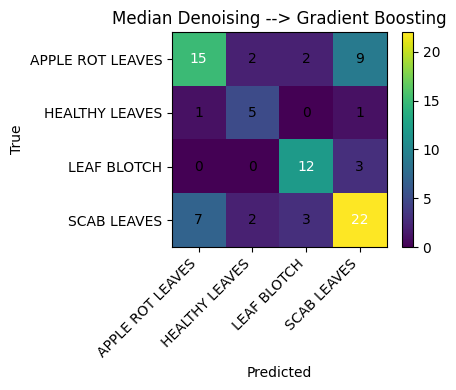

Naive Bayes: accuracy = 0.369
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.54      0.25      0.34        28
  HEALTHY LEAVES       0.33      1.00      0.50         7
     LEAF BLOTCH       0.32      0.87      0.46        15
     SCAB LEAVES       0.44      0.12      0.19        34

        accuracy                           0.37        84
       macro avg       0.41      0.56      0.37        84
    weighted avg       0.44      0.37      0.31        84



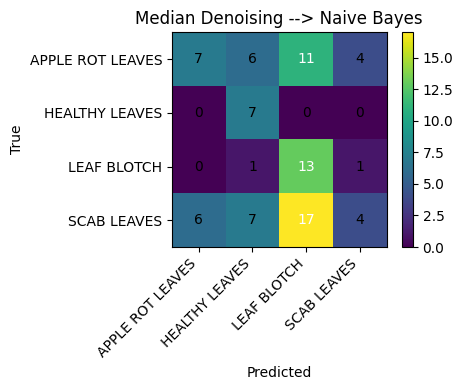

Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM (GridSearch RBF): accuracy = 0.583
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.76      0.57      0.65        28
  HEALTHY LEAVES       0.45      0.71      0.56         7
     LEAF BLOTCH       0.47      0.60      0.53        15
     SCAB LEAVES       0.58      0.56      0.57        34

        accuracy                           0.58        84
       macro avg       0.57      0.61      0.58        84
    weighted avg       0.61      0.58      0.59        84



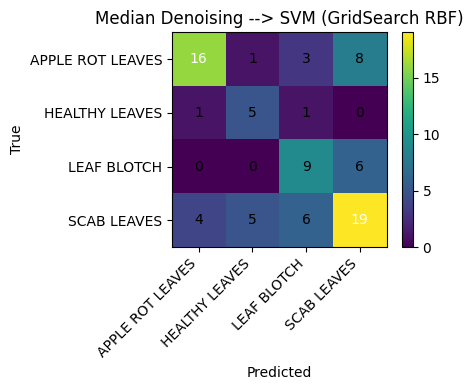

,Model,Accuracy
0,Gradient Boosting,0.642857
1,SVM (GridSearch RBF),0.583333
2,KNN,0.547619
3,Logistic Regression,0.547619
4,Random Forest,0.547619
5,SVM (Linear),0.523810
6,SVM (RBF),0.476190
7,Naive Bayes,0.369048


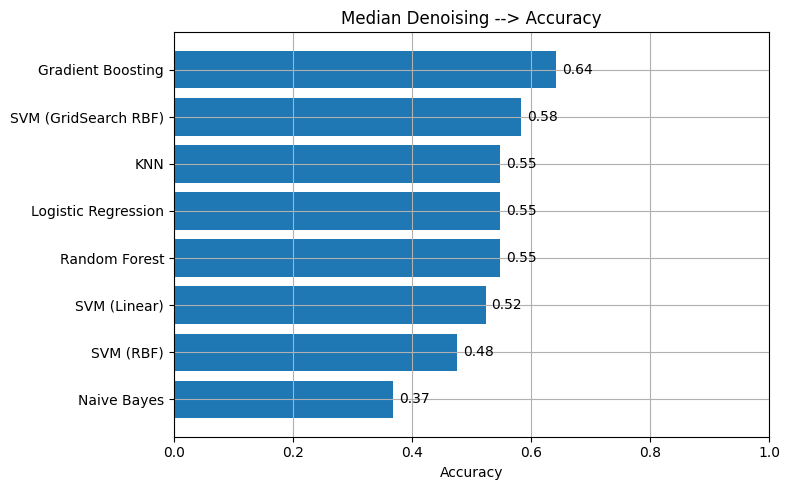


 >>> Applying Bilateral denoising...

 ==== Bilateral Denoising ====
SVM (Linear): accuracy = 0.560
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.76      0.68      0.72        28
  HEALTHY LEAVES       0.36      0.57      0.44         7
     LEAF BLOTCH       0.47      0.53      0.50        15
     SCAB LEAVES       0.52      0.47      0.49        34

        accuracy                           0.56        84
       macro avg       0.53      0.56      0.54        84
    weighted avg       0.58      0.56      0.56        84



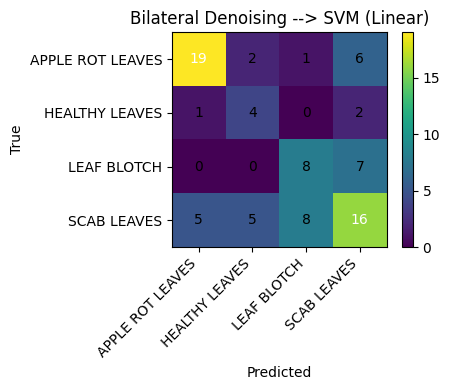

SVM (RBF): accuracy = 0.452
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.78      0.25      0.38        28
  HEALTHY LEAVES       0.00      0.00      0.00         7
     LEAF BLOTCH       0.33      0.13      0.19        15
     SCAB LEAVES       0.43      0.85      0.57        34

        accuracy                           0.45        84
       macro avg       0.38      0.31      0.28        84
    weighted avg       0.49      0.45      0.39        84



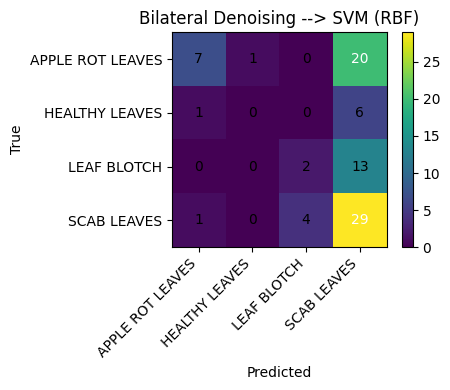

Logistic Regression: accuracy = 0.512
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.67      0.50      0.57        28
  HEALTHY LEAVES       0.33      0.29      0.31         7
     LEAF BLOTCH       0.44      0.53      0.48        15
     SCAB LEAVES       0.49      0.56      0.52        34

        accuracy                           0.51        84
       macro avg       0.48      0.47      0.47        84
    weighted avg       0.53      0.51      0.51        84



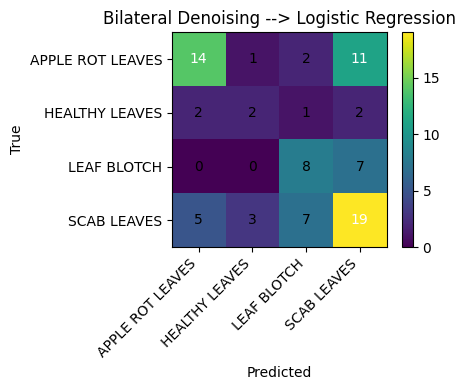

KNN: accuracy = 0.524
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.64      0.50      0.56        28
  HEALTHY LEAVES       0.50      0.57      0.53         7
     LEAF BLOTCH       0.42      0.53      0.47        15
     SCAB LEAVES       0.51      0.53      0.52        34

        accuracy                           0.52        84
       macro avg       0.52      0.53      0.52        84
    weighted avg       0.54      0.52      0.53        84



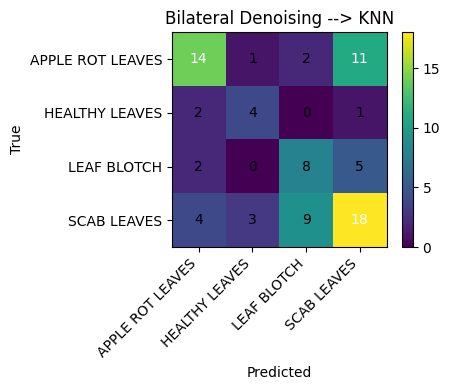

Random Forest: accuracy = 0.595
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.75      0.54      0.62        28
  HEALTHY LEAVES       0.42      0.71      0.53         7
     LEAF BLOTCH       0.52      0.80      0.63        15
     SCAB LEAVES       0.62      0.53      0.57        34

        accuracy                           0.60        84
       macro avg       0.58      0.64      0.59        84
    weighted avg       0.63      0.60      0.60        84



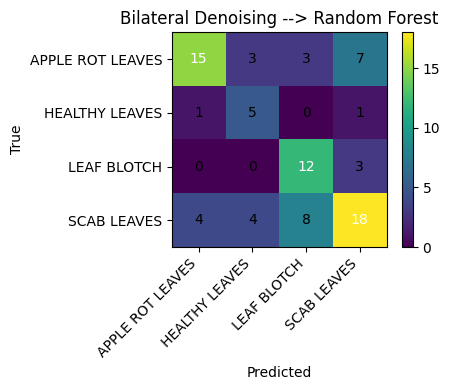

Gradient Boosting: accuracy = 0.643
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.73      0.57      0.64        28
  HEALTHY LEAVES       0.50      0.71      0.59         7
     LEAF BLOTCH       0.67      0.67      0.67        15
     SCAB LEAVES       0.62      0.68      0.65        34

        accuracy                           0.64        84
       macro avg       0.63      0.66      0.64        84
    weighted avg       0.65      0.64      0.64        84



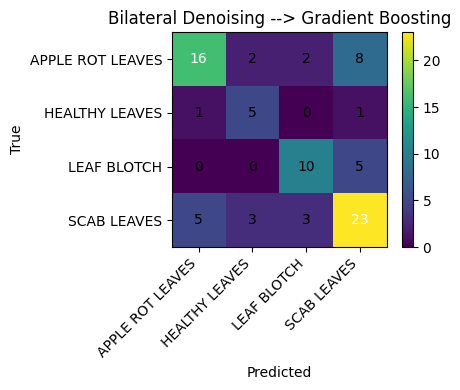

Naive Bayes: accuracy = 0.369
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.58      0.25      0.35        28
  HEALTHY LEAVES       0.30      1.00      0.47         7
     LEAF BLOTCH       0.31      0.87      0.46        15
     SCAB LEAVES       0.57      0.12      0.20        34

        accuracy                           0.37        84
       macro avg       0.44      0.56      0.37        84
    weighted avg       0.51      0.37      0.32        84



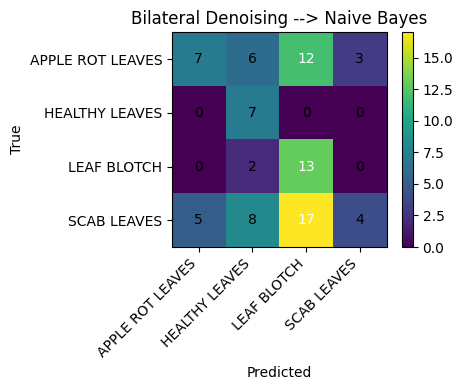

Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM (GridSearch RBF): accuracy = 0.607
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.76      0.57      0.65        28
  HEALTHY LEAVES       0.45      0.71      0.56         7
     LEAF BLOTCH       0.55      0.73      0.63        15
     SCAB LEAVES       0.59      0.56      0.58        34

        accuracy                           0.61        84
       macro avg       0.59      0.64      0.60        84
    weighted avg       0.63      0.61      0.61        84



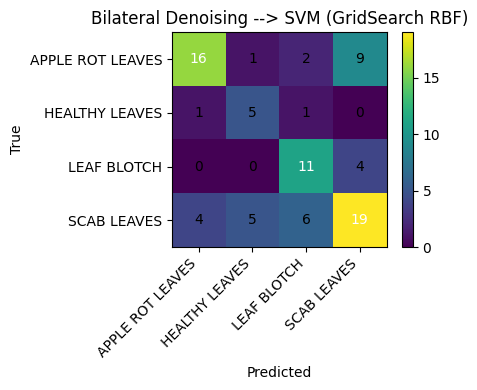

,Model,Accuracy
0,Gradient Boosting,0.642857
1,SVM (GridSearch RBF),0.607143
2,Random Forest,0.595238
3,SVM (Linear),0.559524
4,KNN,0.523810
5,Logistic Regression,0.511905
6,SVM (RBF),0.452381
7,Naive Bayes,0.369048


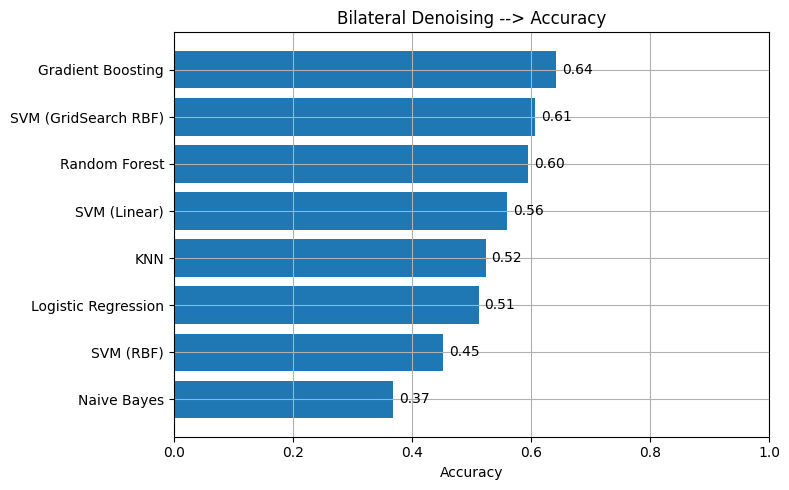


 >>> Applying NLMeans denoising...

 ==== NLMeans Denoising ====
SVM (Linear): accuracy = 0.536
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.80      0.57      0.67        28
  HEALTHY LEAVES       0.27      0.57      0.36         7
     LEAF BLOTCH       0.45      0.67      0.54        15
     SCAB LEAVES       0.56      0.44      0.49        34

        accuracy                           0.54        84
       macro avg       0.52      0.56      0.52        84
    weighted avg       0.59      0.54      0.55        84



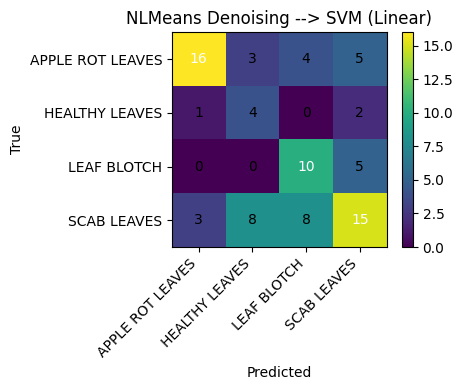

SVM (RBF): accuracy = 0.452
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.78      0.25      0.38        28
  HEALTHY LEAVES       0.00      0.00      0.00         7
     LEAF BLOTCH       0.38      0.20      0.26        15
     SCAB LEAVES       0.42      0.82      0.56        34

        accuracy                           0.45        84
       macro avg       0.39      0.32      0.30        84
    weighted avg       0.50      0.45      0.40        84



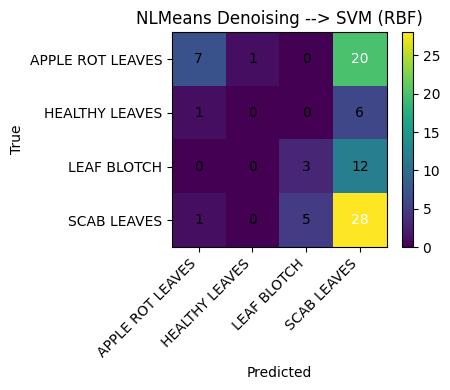

Logistic Regression: accuracy = 0.512
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.83      0.54      0.65        28
  HEALTHY LEAVES       0.50      0.57      0.53         7
     LEAF BLOTCH       0.31      0.53      0.39        15
     SCAB LEAVES       0.50      0.47      0.48        34

        accuracy                           0.51        84
       macro avg       0.54      0.53      0.52        84
    weighted avg       0.58      0.51      0.53        84



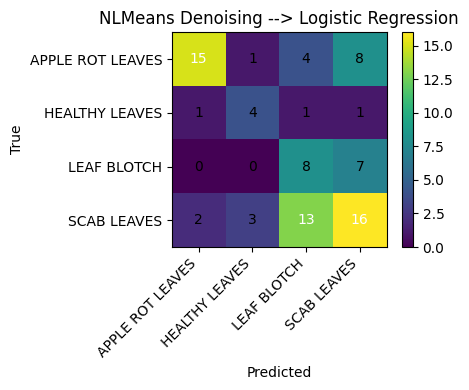

KNN: accuracy = 0.548
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.71      0.43      0.53        28
  HEALTHY LEAVES       0.57      0.57      0.57         7
     LEAF BLOTCH       0.47      0.53      0.50        15
     SCAB LEAVES       0.51      0.65      0.57        34

        accuracy                           0.55        84
       macro avg       0.56      0.55      0.54        84
    weighted avg       0.57      0.55      0.55        84



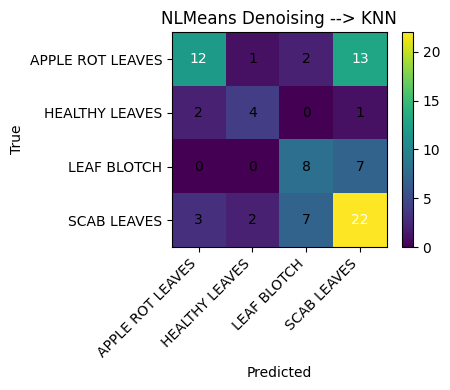

Random Forest: accuracy = 0.560
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.77      0.61      0.68        28
  HEALTHY LEAVES       0.38      0.71      0.50         7
     LEAF BLOTCH       0.50      0.53      0.52        15
     SCAB LEAVES       0.52      0.50      0.51        34

        accuracy                           0.56        84
       macro avg       0.54      0.59      0.55        84
    weighted avg       0.59      0.56      0.57        84



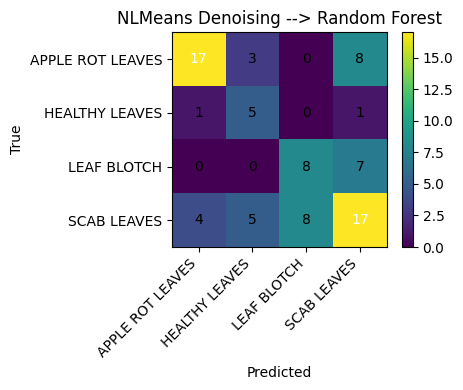

Gradient Boosting: accuracy = 0.500
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.64      0.50      0.56        28
  HEALTHY LEAVES       0.50      0.71      0.59         7
     LEAF BLOTCH       0.40      0.53      0.46        15
     SCAB LEAVES       0.47      0.44      0.45        34

        accuracy                           0.50        84
       macro avg       0.50      0.55      0.51        84
    weighted avg       0.51      0.50      0.50        84



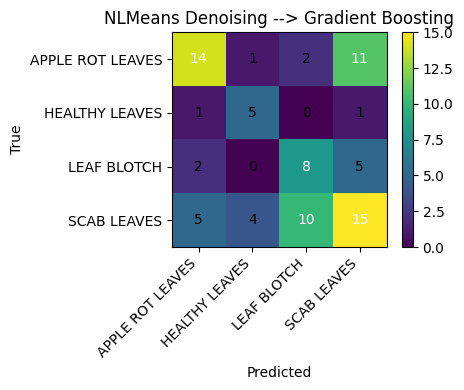

Naive Bayes: accuracy = 0.369
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.64      0.25      0.36        28
  HEALTHY LEAVES       0.29      1.00      0.45         7
     LEAF BLOTCH       0.31      0.87      0.46        15
     SCAB LEAVES       0.57      0.12      0.20        34

        accuracy                           0.37        84
       macro avg       0.45      0.56      0.37        84
    weighted avg       0.52      0.37      0.32        84



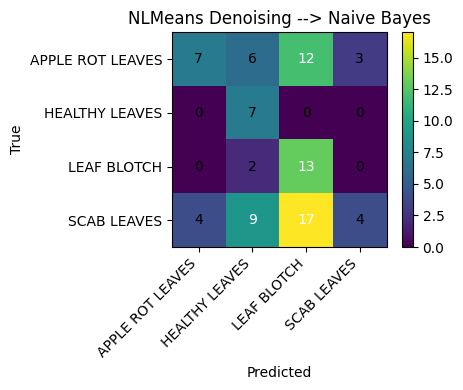

Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM (GridSearch RBF): accuracy = 0.607
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.74      0.61      0.67        28
  HEALTHY LEAVES       0.50      0.71      0.59         7
     LEAF BLOTCH       0.53      0.67      0.59        15
     SCAB LEAVES       0.59      0.56      0.58        34

        accuracy                           0.61        84
       macro avg       0.59      0.64      0.60        84
    weighted avg       0.62      0.61      0.61        84



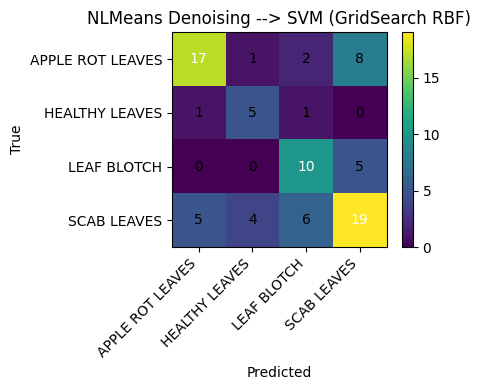

,Model,Accuracy
0,SVM (GridSearch RBF),0.607143
1,Random Forest,0.559524
2,KNN,0.547619
3,SVM (Linear),0.535714
4,Logistic Regression,0.511905
5,Gradient Boosting,0.500000
6,SVM (RBF),0.452381
7,Naive Bayes,0.369048


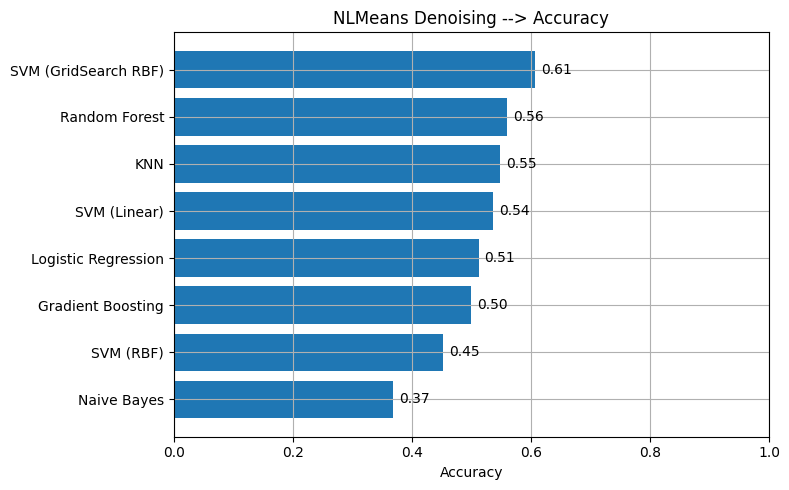

In [20]:
# denoiser loop
denoiser_funcs = OrderedDict([
    ("Gaussian", denoise_gaussian),
    ("Median", denoise_median),
    ("Bilateral", denoise_bilateral),
    ("NLMeans", denoise_nlmeans_colored),
])

all_results = {"Original": acc_orig} # to include baseline in final table
all_tables = {"Original": df_orig}

for name, func in denoiser_funcs.items():
    print(f"\n >>> Applying {name} denoising...")
    X_d = func(X)
    accs, df = run_all_classifiers(X_d, y, originals, label=f"{name} Denoising", show_confusion=True, classes=class_names)
    all_results[name] = accs
    all_tables[name] = df
    plot_accuracy_table(df, title=f"{name} Denoising --> Accuracy")
    


 ==== KernelPCA Denoising (n_components=100, gamma=0.0001) ====


C:\Users\destr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVM (Linear): accuracy = 0.417
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.50      0.39      0.44        28
  HEALTHY LEAVES       0.50      0.57      0.53         7
     LEAF BLOTCH       0.35      0.53      0.42        15
     SCAB LEAVES       0.39      0.35      0.37        34

        accuracy                           0.42        84
       macro avg       0.43      0.46      0.44        84
    weighted avg       0.43      0.42      0.42        84


SVM (RBF): accuracy = 0.571
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.62      0.64      0.63        28
  HEALTHY LEAVES       0.45      0.71      0.56         7
     LEAF BLOTCH       0.48      0.73      0.58        15
     SCAB LEAVES       0.67      0.41      0.51        34

        accuracy                           0.57        84
       macro avg       0.56      0.63      0.57        84
    weighted avg       0.60      0.57      0.57        84


Logi

,Model,Accuracy
0,Random Forest,0.583333
1,SVM (RBF),0.571429
2,Logistic Regression,0.559524
3,KNN,0.559524
4,Gradient Boosting,0.523810
5,SVM (Linear),0.416667
6,Naive Bayes,0.369048


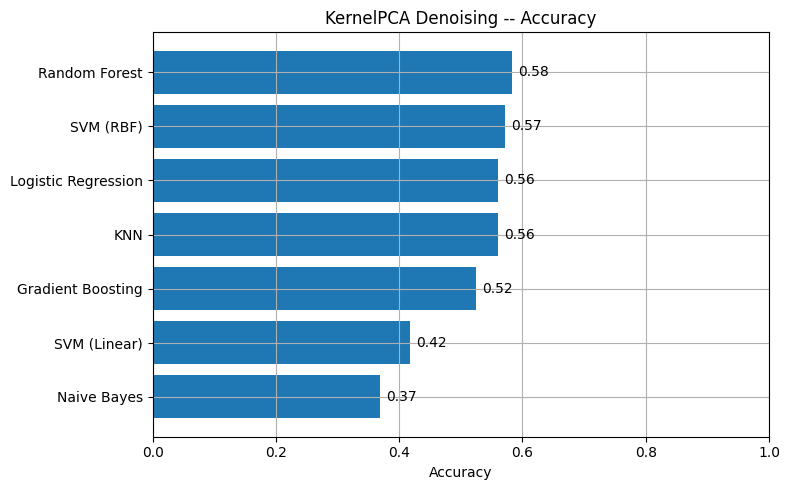

In [21]:
#KernelPCA
from sklearn.decomposition import KernelPCA

# split first to avoid leakage
def kpca_denoise(X_data, y_data, originals_data, n_components=100, gamma=1e-4, label_suffix=""):
    X_train, X_test, y_train, y_test, train_orig, test_orig = train_test_split(
        X_data, y_data, originals_data, test_size=0.2, random_state=random_state)

    # scale before KPCA
    pre_scaler = StandardScaler()
    X_train_s = pre_scaler.fit_transform(X_train)
    X_test_s = pre_scaler.transform(X_test)

    # fit KPCA on train only
    kpca = KernelPCA(
        n_components=n_components, 
        kernel='rbf', 
        gamma=gamma,
        fit_inverse_transform=True, 
        random_state=random_state
    )
    kpca.fit(X_train_s)

    # Reconstructing denoised
    X_train_kpca = kpca.inverse_transform(kpca.transform(X_train_s))
    X_test_kpca = kpca.inverse_transform(kpca.transform(X_test_s))

    # scaling again for classifiers (this is a fresh scaler)
    scaler_cls = StandardScaler()
    X_train_k = scaler_cls.fit_transform(X_train_kpca)
    X_test_k = scaler_cls.transform(X_test_kpca)

    # train/eval (resuing the build_classifiers)
    models =  build_classifiers()
    accs = OrderedDict()

    label = f"KernelPCA Denoising {label_suffix}".strip()
    print(f"\n ==== {label} (n_components={n_components}, gamma={gamma}) ====")
    for name, clf in models.items():
        clf.fit(X_train_k, y_train)
        y_pred = clf.predict(X_test_k)
        acc = accuracy_score(y_test, y_pred)
        accs[name] = acc
        print(f"\n{name}: accuracy = {acc:.3f}")
        print(classification_report(y_test, y_pred))


    df = pd.DataFrame({"Model": list(accs.keys()), "Accuracy": list(accs.values())})
    df = df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
    display(df)
    return accs, df


acc_kpca, df_kpca = kpca_denoise(X, y, originals, n_components=100, gamma=1e-4)
plot_accuracy_table(df_kpca, title="KernelPCA Denoising -- Accuracy")

all_results["KernelPCA"] = acc_kpca
all_tables["KernelPCA"] = df_kpca
                                          
    

,Original,Gaussian,Median,Bilateral,NLMeans,KernelPCA
Gradient Boosting,0.547619,0.630952,0.642857,0.642857,0.500000,0.523810
KNN,0.547619,0.511905,0.547619,0.523810,0.547619,0.559524
Logistic Regression,0.535714,0.559524,0.547619,0.511905,0.511905,0.559524
Naive Bayes,0.357143,0.369048,0.369048,0.369048,0.369048,0.369048
Random Forest,0.559524,0.571429,0.547619,0.595238,0.559524,0.583333
SVM (GridSearch RBF),0.619048,0.642857,0.583333,0.607143,0.607143,NaN
SVM (Linear),0.488095,0.511905,0.523810,0.559524,0.535714,0.416667
SVM (RBF),0.476190,0.488095,0.476190,0.452381,0.452381,0.571429


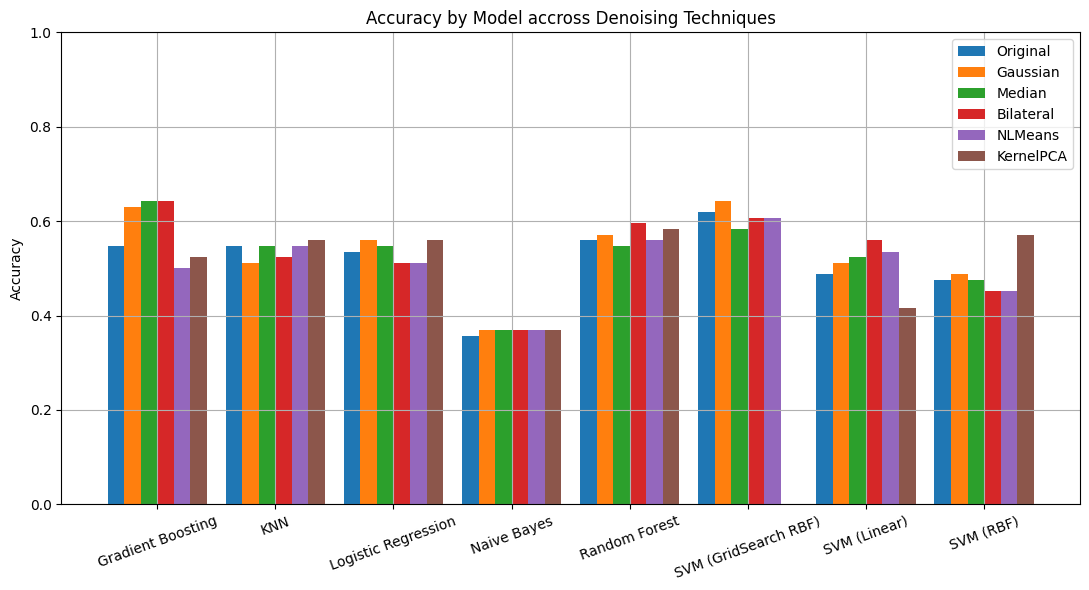

In [22]:
# Grand Comparison

all_models = sorted(set().union(*[set(d.keys()) for d in all_results.values()]))
wide = {}

for model in all_models:
    wide[model] = {}
    for tech, d in all_results.items():
        wide[model][tech] = d.get(model, np.nan)

results_wide_df = pd.DataFrame.from_dict(wide, orient='index')[["Original","Gaussian","Median","Bilateral", "NLMeans", "KernelPCA"]]
rerults_wide_df = results_wide_df.sort_values(by="Original", ascending=True)
display(results_wide_df)

# Grouped bar chart 
plt.figure(figsize=(11,6))
techniques = results_wide_df.columns.tolist()
x = np.arange(len(results_wide_df.index))
width = 0.14

for i, tech in enumerate(techniques):
    plt.bar(x + i*width - (len(techniques) - 1)*width/2, results_wide_df[tech].values, width=width, label=tech)


plt.xticks(x, results_wide_df.index, rotation=20)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Accuracy by Model accross Denoising Techniques")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Deciding Best Technique and re-creating denoised dataset 

In [23]:
best_tech = "Gaussian"

# recreating denoised dataset

tech_to_func = {
    "Original": denoise_none,
    "Gaussian": denoise_gaussian,
    "Median": denoise_median,
    "Bilateral": denoise_bilateral,
    "NLMeans": denoise_nlmeans_colored,
}
X_best = tech_to_func[best_tech](X)

In [24]:
# Split/Scale

X_train, X_test, y_train, y_test = train_test_split(
    X_best, y, test_size=0.2, random_state=random_state, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [25]:
# GridSearchCV

param_grid = {
    "C": [0.1, 1, 5, 10, 50],
    "gamma": ["scale", 0.001, 0.01, 0.1],
    "kernel": ["rbf"]
}
grid = GridSearchCV(SVC(random_state=random_state), param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_s, y_train)
print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}



 Tuned SVM on Gaussian --> accuracy: 0.6904761904761905
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.71      0.57      0.63        21
  HEALTHY LEAVES       0.50      0.44      0.47         9
     LEAF BLOTCH       0.81      0.77      0.79        22
     SCAB LEAVES       0.66      0.78      0.71        32

        accuracy                           0.69        84
       macro avg       0.67      0.64      0.65        84
    weighted avg       0.69      0.69      0.69        84



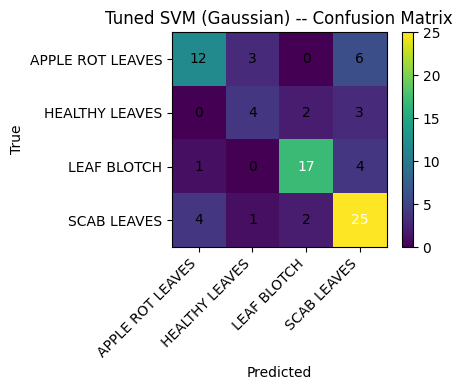

In [26]:
# Evaluate tuned SVM
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test_s)

print("\n Tuned SVM on", best_tech, "--> accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plot_confusion_matrix(cm, classes=class_names, title=f"Tuned SVM ({best_tech}) -- Confusion Matrix")

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_best, y, test_size=0.2, random_state=random_state, stratify=y
)
scaler_err = StandardScaler().fit(X_train)
X_test_s = scaler_err.transform(X_test)

y_pred = best_svm.predict(X_test_s)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=class_names)
print(cm)
print("\nClassification report:")
print(classification_report(y_test, y_pred, labels=class_names))
      

def show_misclassifications(originals_all, idx_test, y_true, y_pred, n=6):
    mism = np.where(y_true != y_pred)[0][:n]
    if len(mism) == 0:
        print("No Misclassification in the first preview")
        return
    for i in mism:
        plt.figure(figsize=(3,3))
        plt.imshow(originals_all[idx_test[i]])
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
        plt.axis("off")
        plt.show()

Confusion Matrix:
[[12  3  0  6]
 [ 0  4  2  3]
 [ 1  0 17  4]
 [ 4  1  2 25]]

Classification report:
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.71      0.57      0.63        21
  HEALTHY LEAVES       0.50      0.44      0.47         9
     LEAF BLOTCH       0.81      0.77      0.79        22
     SCAB LEAVES       0.66      0.78      0.71        32

        accuracy                           0.69        84
       macro avg       0.67      0.64      0.65        84
    weighted avg       0.69      0.69      0.69        84



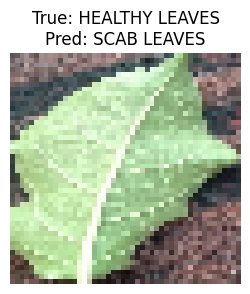

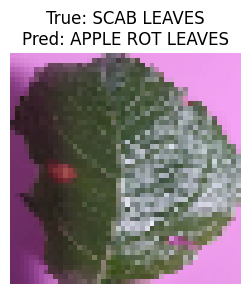

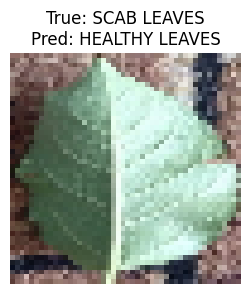

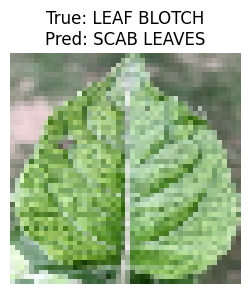

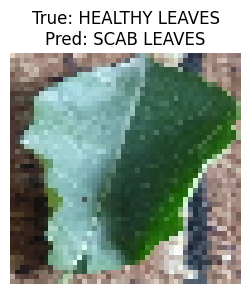

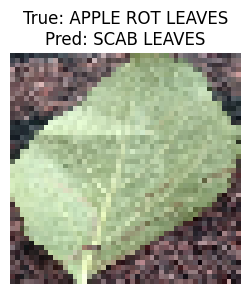

In [28]:
_, idx_test = train_test_split(
    np.arange(len(X_best)), test_size=0.2, random_state=random_state, stratify=y
)

show_misclassifications(originals, idx_test, y_test, y_pred, n=6)